In [ ]:
!pip install nltk
!pip install chart-studio

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize

from bs4 import BeautifulSoup
import plotly.graph_objs as go
from chart_studio import plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
df_data = pd.read_csv('kaggle_movie_train.csv')

In [ ]:
df_data.head(5)

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


In [ ]:
df_data.drop(columns= 'id', inplace= True)

In [ ]:
df_data['text']

0        eady dead, maybe even wishing he was. INT. 2ND...
1        t, summa cum laude and all. And I'm about to l...
2         up Come, I have a surprise.... She takes him ...
3        ded by the two detectives. INT. JEFF'S APARTME...
4        nd dismounts, just as the other children reach...
                               ...                        
22574    n in the world to decide what I'm going to do ...
22575    shards. BOJO LAZ! Laz pushes Deke back through...
22576    OTTIE You've got a thing about Ernie's, haven'...
22577    ....with marked skill and dexterity . LANA wry...
22578    rd walks off down the hallway, leaving his pos...
Name: text, Length: 22579, dtype: object

In [ ]:
import string
translator = str.maketrans('','',string.punctuation)
df_data['text'] = df_data.apply(lambda row : row['text'].translate(translator), axis = 1)

In [ ]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')


STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text


    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df_data['text'] = df_data['text'].apply(clean_text) 

In [ ]:
df_data['text']

0        eady dead maybe even wishing int 2nd floor hal...
1        summa cum laude im launch brand new magazine c...
2        come surprise takes hand leads hallway salvato...
3        ded two detectives int jeffs apartment night m...
4        nd dismounts children reach throw arms embraci...
                               ...                        
22574    n world decide im going thats think think emil...
22575    shards bojo laz laz pushes deke back joint sla...
22576    ottie youve got thing ernies havent judy well ...
22577    marked skill dexterity lana wryly youd surpris...
22578    rd walks hallway leaving post end hallway see ...
Name: text, Length: 22579, dtype: object

In [ ]:
"""from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
  
df_data['genre']= label_encoder.fit_transform(df_data['genre']) 
  
df_data['genre'].unique() """

"from sklearn import preprocessing \nlabel_encoder = preprocessing.LabelEncoder() \n  \ndf_data['genre']= label_encoder.fit_transform(df_data['genre']) \n  \ndf_data['genre'].unique() "

In [ ]:
df_data.head(5)
len(df_data['text'])

,text,genre
0,eady dead maybe even wishing int 2nd floor hal...,thriller
1,summa cum laude im launch brand new magazine c...,comedy
2,come surprise takes hand leads hallway salvato...,drama
3,ded two detectives int jeffs apartment night m...,thriller
4,nd dismounts children reach throw arms embraci...,drama


22579

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_data['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
tokenizer.word_index

Found 73057 unique tokens.


{'int': 1,
 'back': 2,
 'one': 3,
 'dont': 4,
 'looks': 5,
 'like': 6,
 'im': 7,
 'day': 8,
 'night': 9,
 'know': 10,
 'ext': 11,
 'get': 12,
 'door': 13,
 'room': 14,
 'see': 15,
 'man': 16,
 'around': 17,
 'right': 18,
 'go': 19,
 'two': 20,
 'look': 21,
 'youre': 22,
 'got': 23,
 'turns': 24,
 'well': 25,
 'away': 26,
 'hes': 27,
 'time': 28,
 'hand': 29,
 'face': 30,
 'cut': 31,
 'eyes': 32,
 'head': 33,
 'going': 34,
 'thats': 35,
 'want': 36,
 'come': 37,
 'car': 38,
 'think': 39,
 'way': 40,
 'behind': 41,
 'something': 42,
 'little': 43,
 'still': 44,
 'takes': 45,
 'looking': 46,
 'good': 47,
 'oh': 48,
 'house': 49,
 'shot': 50,
 'open': 51,
 'close': 52,
 'voice': 53,
 'another': 54,
 'us': 55,
 'take': 56,
 'cant': 57,
 'toward': 58,
 'ill': 59,
 'front': 60,
 'mr': 61,
 'hands': 62,
 'long': 63,
 'starts': 64,
 'old': 65,
 'comes': 66,
 'tell': 67,
 'pulls': 68,
 'say': 69,
 'goes': 70,
 'jack': 71,
 'yes': 72,
 'across': 73,
 'first': 74,
 'side': 75,
 'make': 76,
 'beat'

In [ ]:
X = tokenizer.texts_to_sequences(df_data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (22579, 250)


In [ ]:
Y = pd.get_dummies(df_data['genre']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (22579, 9)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.80, random_state = 42)
X_test = X_test[0:2100]
Y_test = Y_test[0:2100]
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4515, 250) (4515, 9)
(2100, 250) (2100, 9)


In [ ]:
import keras.metrics
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 6
batch_size = 10

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/6
407/407 [==============================] - 188s 454ms/step - loss: 1.6482 - accuracy: 0.3631 - precision: 0.4166 - recall: 0.0433 - val_loss: 1.5626 - val_accuracy: 0.3695 - val_precision: 1.0000 - val_recall: 0.0022
Epoch 2/6
407/407 [==============================] - 184s 453ms/step - loss: 1.1766 - accuracy: 0.5910 - precision: 0.7787 - recall: 0.3558 - val_loss: 1.1258 - val_accuracy: 0.6416 - val_precision: 0.7190 - val_recall: 0.5265
Epoch 3/6
407/407 [==============================] - 184s 451ms/step - loss: 0.3174 - accuracy: 0.9045 - precision: 0.9592 - recall: 0.8695 - val_loss: 1.1831 - val_accuracy: 0.6062 - val_precision: 0.6839 - val_recall: 0.4978
Epoch 4/6
407/407 [==============================] - 184s 451ms/step - loss: 0.1203 - accuracy: 0.9664 - precision: 0.9850 - recall: 0.9405 - val_loss: 1.1492 - val_accuracy: 0.6350 - val_precision: 0.6911 - val_recall: 0.6040
Epoch 5/6
407/407 [==============================] - 185s 454ms/step - loss: 0.0452 - accura

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

66/66 [==============================] - 4s 67ms/step - loss: 1.4045 - accuracy: 0.5990 - precision: 0.6349 - recall: 0.5424
Test set
  Loss: 1.404
  Accuracy: 0.599


In [ ]:
history.history

{'accuracy': [0.36500123143196106,
  0.6618262529373169,
  0.9101648926734924,
  0.9638198614120483,
  0.9859709739685059],
 'loss': [1.5703116655349731,
  1.0107831954956055,
  0.2893115282058716,
  0.11669889837503433,
  0.04880416765809059],
 'precision': [0.42500001192092896,
  0.794684112071991,
  0.9576819539070129,
  0.9830812811851501,
  0.9922577142715454],
 'recall': [0.016736401244997978,
  0.5077528953552246,
  0.874476969242096,
  0.9438838362693787,
  0.9778488874435425],
 'val_accuracy': [0.36946901679039,
  0.6415929198265076,
  0.6061946749687195,
  0.6349557638168335,
  0.5951327681541443],
 'val_loss': [1.562601089477539,
  1.1257703304290771,
  1.1830776929855347,
  1.1492077112197876,
  1.3347930908203125],
 'val_precision': [1.0,
  0.7190332412719727,
  0.6838905811309814,
  0.6911392211914062,
  0.633074939250946],
 'val_recall': [0.0022123893722891808,
  0.5265486836433411,
  0.49778762459754944,
  0.6039823293685913,
  0.5420354008674622]}

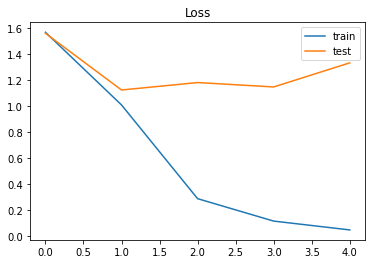

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

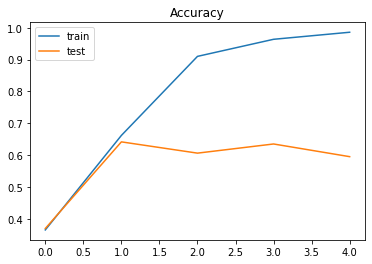

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
### implemented by following this: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17